<a href="https://colab.research.google.com/github/Nicoxfl/Nicoxfl-MIT-Certificate-Data-Science/blob/main/Module_13_Optimization_Landfill_Case_Study1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  
## Problem Description

There are six end landfills, each with a known demand for a waste material.  Landfill demand can be satisfied from a set of four transfer station depots, or directly from a set of two waste generating centers.  Each transfer depot can support a maximum volume of waste moving through it, and each waste generating center can generate a maximum amount of waste.  There are known costs associated with transporting the waste, from a center to a depot, from a depot to a landfill, or from a center directly to a landfill.

The waste network has two waste generating centers, in NewYork and NewJersey, which generate the waste.  Each has a maximum waste generating volume:

| Center | Waste (tons) |
| --- | --- |
| NewYork | 300,000 |
| NewJersey |  400,000 |

The waste can be shipped from a center to a set of four depots. Each depot has a maximum throughput.

| Depot | Throughput (tons) |
| --- | --- |
| Bronx | 140,000 |
| Brooklyn | 100,000 |
| Queens | 200,000 |
| StatenIsland | 80,000 |

Our network has six landfills, each with a given maxiumum demand.

| Landfill | Demand (tons) |
| --- | --- |
| C1 | 100,000 |
| C2 | 20,000 |
| C3 | 80,000 |
| C4 | 70,000 |
| C5 | 120,000 |
| C6 | 40,000 |
| C7 | 80,000 |
| C8 | 60,000 |

Transporation costs are given in the following table (in dollars per ton).  Columns are source cities and rows are destination cities.  

| To | NewYork | NewJersey | Bronx | Brooklyn | Queens | StatenIsland |
| --- | --- | --- | --- | --- | --- | --- |
| Depots |
| Bronx  | 0.7 |   - |
| Brooklyn | 0.7 | 0.5 |
| Queens     | 1.2 | 0.7 |
| StatenIsland     | 0.4 | 0.4 |
| Landfills |
| C1 | 1.2 | 2.2 |   - | 1.2 |   - |   - |
| C2 |   - |   - | 1.7 | 0.7 | 1.7 |   - |
| C3 | 1.7 |   - | 0.7 | 0.75 | 2.2 | 0.4 |
| C4 | 2.2 |   - | 1.7 | 1.2|   - | 1.7 |
| C5 |   - |   - |   - | 0.7 | 0.7 | 0.7 |
| C6 | 1.2 |   - | 1.2 |   - | 1.7 | 1.7 |
| C7 | 1.4 |   - | 0.9 | 1.1|   - | 1.9 |
| C8 |   - |   - |   - | 0.9 | 0.5 | 0.6 |

Question: How to satisfy the demands of the end Landfills while minimizing shipping costs.

---
## Model Formulation

### Sets and Indices

$f \in \text{Centers}=\{\text{NewYork}, \text{NewJersey}\}$

$d \in \text{Depots}=\{\text{Bronx}, \text{Brooklyn}, \text{Queens}, \text{StatenIsland}\}$

$c \in \text{Landfills}=\{\text{C1}, \text{C2}, \text{C3}, \text{C4}, \text{C5}, \text{C6}\}$

$\text{Locations} = \text{Centers} \cup \text{Depots} \cup \text{Landfills}$

### Parameters

$\text{cost}_{s,t} \in \mathbb{R}^+$: Cost of shipping one ton from source $s$ to destination $t$.

$\text{supply}_f \in \mathbb{R}^+$: Maximum possible supply from center $f$ (in tons).

$\text{through}_d \in \mathbb{R}^+$: Maximum possible flow through depot $d$ (in tons).

$\text{demand}_c \in \mathbb{R}^+$: Demand for waste at landfill $c$ (in tons).

### Decision Variables

$\text{flow}_{s,t} \in \mathbb{N}^+$: Quantity of waste (in tons) that is shipped from source $s$ to destionation $t$.


### Objective Function

- **Cost**: Minimize total shipping costs.

\begin{equation}
\text{Minimize} \quad Z = \sum_{(s,t) \in \text{locations} \times \text{locations}}{\text{cost}_{s,t}*\text{flow}_{s,t}}
\end{equation}

### Constraints

- **Center output**: Flow of goods from a factory must respect maximum capacity.

\begin{equation}
\sum_{t \in \text{locations}}{\text{flow}_{f,t}} \leq \text{supply}_{f} \quad \forall f \in \text{Centers}
\end{equation}

- **Landfill demand**: Flow of goods must meet customer demand.

\begin{equation}
\sum_{s \in \text{locations}}{\text{flow}_{s,c}} = \text{demand}_{c} \quad \forall c \in \text{Landfills}
\end{equation}

- **Depot flow**: Flow into a depot equals flow out of the depot.

\begin{equation}
\sum_{s \in \text{locations}}{\text{flow}_{s,d}} =
\sum_{t \in \text{locations}}{\text{flow}_{d,t}}
\quad \forall d \in \text{Depots}
\end{equation}

- **Depot capacity**: Flow into a depot must respect depot capacity.

\begin{equation}
\sum_{s \in \text{locations}}{\text{flow}_{s,d}} \leq \text{through}_{d}
\quad \forall d \in \text{Depots}
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [ ]:
%pip install gurobipy

In [ ]:
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.7.0 & Gurobi 9.0

## Input Data
We define all the input data for the model.

In [ ]:
# Create dictionaries to capture center supply limits, depot throughput limits, and landfill demand.

supply = dict({'NewYork': 300000,
               'NewJersey': 400000})

through = dict({'Bronx': 140000,
                'Brooklyn': 100000,
                'Queens': 200000,
                'StatenIsland': 80000})

demand = dict({'C1': 100000,
               'C2': 20000,
               'C3': 80000,
               'C4': 70000,
               'C5': 120000,
               'C6': 40000})

# Create a dictionary to capture shipping costs.

arcs, cost = gp.multidict({
    ('NewYork', 'Bronx'): 0.7,
    ('NewYork', 'Brooklyn'): 0.7,
    ('NewYork', 'Queens'): 1.2,
    ('NewYork', 'StatenIsland'): 0.4,
    ('NewYork', 'C1'): 1.2,
    ('NewYork', 'C3'): 1.7,
    ('NewYork', 'C4'): 2.2,
    ('NewYork', 'C6'): 1.2,
    ('NewJersey', 'Brooklyn'): 0.5,
    ('NewJersey', 'Queens'): 0.7,
    ('NewJersey', 'StatenIsland'): 0.4,
    ('NewJersey', 'C1'): 2.2,
    ('Bronx', 'C2'): 1.7,
    ('Bronx', 'C3'): 0.7,
    ('Bronx', 'C4'): 1.7,
    ('Bronx', 'C6'): 1.2,
    ('Brooklyn', 'C1'): 1.2,
    ('Brooklyn', 'C2'): 0.7,
    ('Brooklyn', 'C3'): 0.7,
    ('Brooklyn', 'C4'): 1.2,
    ('Brooklyn', 'C5'): 0.7,
    ('Queens', 'C2'): 1.7,
    ('Queens', 'C3'): 2.2,
    ('Queens', 'C5'): 0.7,
    ('Queens', 'C6'): 1.7,
    ('StatenIsland', 'C3'): 0.4,
    ('StatenIsland', 'C4'): 1.7,
    ('StatenIsland', 'C5'): 0.7,
    ('StatenIsland', 'C6'): 1.7,
})

## Model Deployment

Create a model and  variables. The variables simply capture the amount of waste that flows along each allowed path between a source and destination.  Objective coefficients are provided here (in $\text{cost}$) , so we don't need to provide an optimization objective later.

In [ ]:
model = gp.Model('SupplyNetworkDesign')
flow = model.addVars(arcs, obj=cost, name="flow")

First constraints require the total flow along arcs leaving a center to be at most as large as the supply capacity of that center.

In [ ]:
# Center capacity limits

centers = supply.keys()
center_flow = model.addConstrs((gp.quicksum(flow.select(center, '*')) <= supply[center]
                                 for center in centers), name="center")

Next constraints require the total flow along arcs entering a landfill to be equal to the demand from that landfill.

In [ ]:
# landfill demand

landfills = demand.keys()
landfill_flow = model.addConstrs((gp.quicksum(flow.select('*', landfill)) == demand[landfill]
                                  for landfill in landfills), name="landfill")

Final constraints relate to depots.  The first constraints require that the total amount of waste entering the depot must equal the total amount leaving.

In [ ]:
# Depot flow conservation

depots = through.keys()
depot_flow = model.addConstrs((gp.quicksum(flow.select(depot, '*')) == gp.quicksum(flow.select('*', depot))
                               for depot in depots), name="depot")

The second set limits the waste passing through the depot to be at most equal the throughput of that depot.

In [ ]:
# Depot throughput

depot_capacity = model.addConstrs((gp.quicksum(flow.select('*', depot)) <= through[depot]
                                   for depot in depots), name="depot_capacity")

Optimize the model

In [ ]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 16 rows, 29 columns and 65 nonzeros
Model fingerprint: 0x6a0e70a2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+05]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 15 rows, 29 columns, 64 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8200000e+05   3.625000e+04   0.000000e+00      0s
       7    5.4100000e+05   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.410000000e+05


---
## Analysis

Waste demand from all of our landfillss can be satisfied for a total cost of $\$541,000$. The optimal plan is as follows.

In [ ]:
#product_flow = pd.DataFrame(columns=["From", "To", "Flow"])
#for arc in arcs:
#    if flow[arc].x > 1e-6:
#        product_flow = product_flow.append({"From": arc[0], "To": arc[1], "Flow": flow[arc].x}, ignore_index=True)
#product_flow.index=[''] * len(product_flow)
#product_flow

product_flow_data = []

for arc in arcs:
    if flow[arc].x > 1e-6:
        product_flow_data.append({"From": arc[0], "To": arc[1], "Flow": flow[arc].x})

product_flow = pd.DataFrame(product_flow_data)
product_flow.index=[''] * len(product_flow)
product_flow

,From,To,Flow
,NewYork,C1,100000.0
,NewYork,C6,40000.0
,NewJersey,Brooklyn,100000.0
,NewJersey,Queens,110000.0
,NewJersey,StatenIsland,80000.0
,Brooklyn,C2,20000.0
,Brooklyn,C4,70000.0
,Brooklyn,C5,10000.0
,Queens,C5,110000.0
,StatenIsland,C3,80000.0


<ipython-input-30-b6f531937478>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(product_flow, x='Flow', y='From', inner='stick', palette='Dark2')


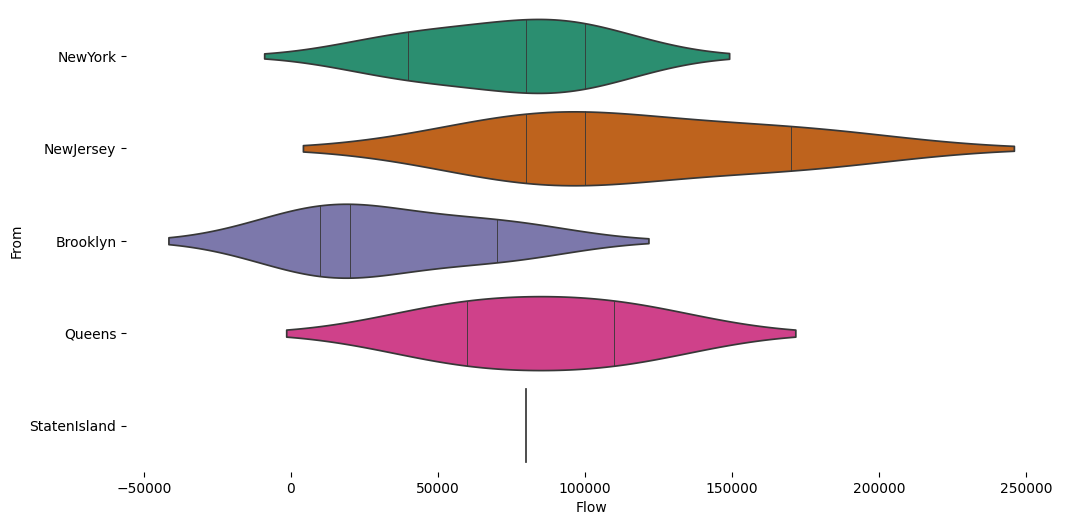

In [ ]:
# @title From vs Flow

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(product_flow['From'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(product_flow, x='Flow', y='From', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

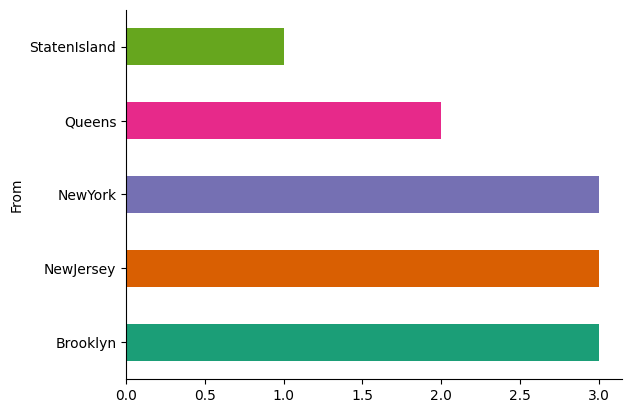

In [ ]:
# @title From

from matplotlib import pyplot as plt
import seaborn as sns
product_flow.groupby('From').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

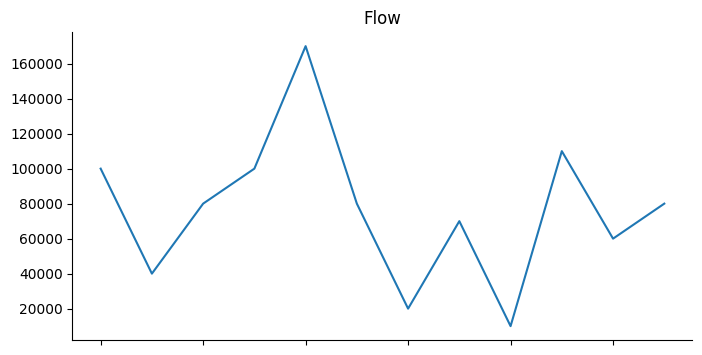

In [ ]:
# @title Flow

from matplotlib import pyplot as plt
product_flow['Flow'].plot(kind='line', figsize=(8, 4), title='Flow')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-12-b6f531937478>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(product_flow, x='Flow', y='From', inner='stick', palette='Dark2')


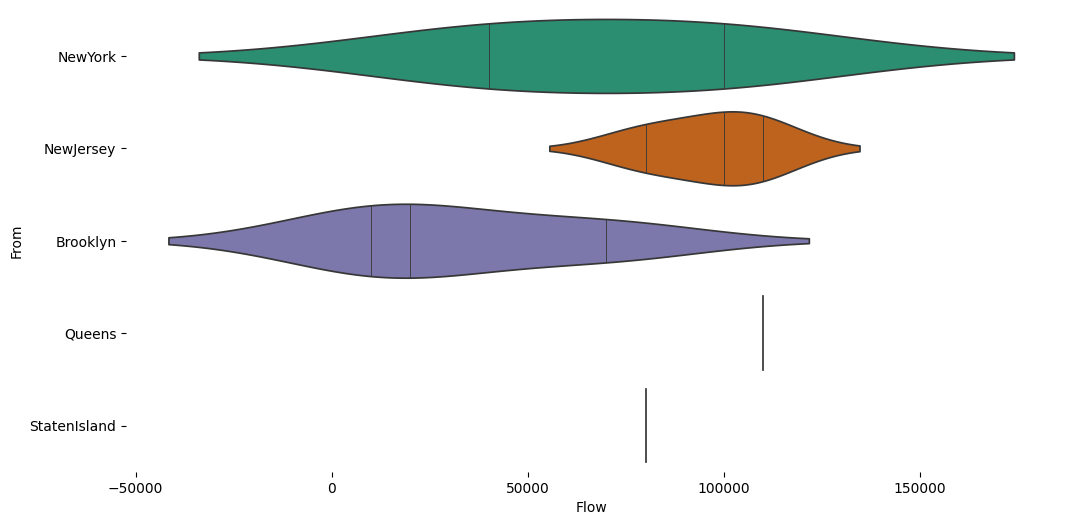

In [ ]:
# @title From vs Flow

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(product_flow['From'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(product_flow, x='Flow', y='From', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)